<a href="https://colab.research.google.com/github/THEEPSHIKAs/value-vision-app/blob/main/modal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter the commodity name (e.g., Apple, Banana, Tomato): Tofu
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0083 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0012 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0011 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.0013 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0016 - val_loss: 0.0022 - learning_rate: 0.0010


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


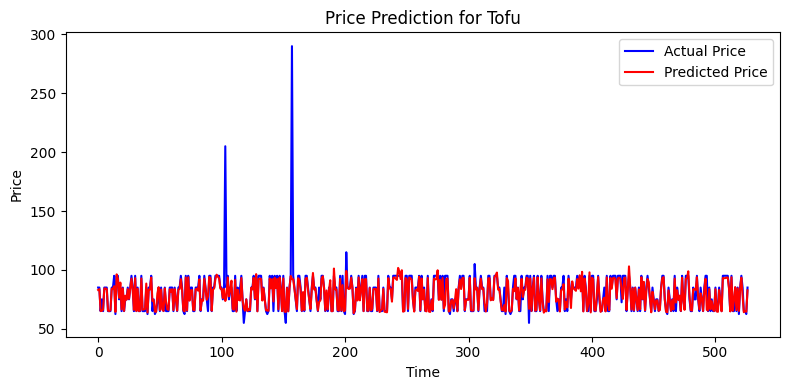

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted price for Tofu: ₹82.63


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('/content/Final.csv')

# Parse dates correctly
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

# Function to scale and prepare the data for LSTM
def prepare_data(data, commodity_name, time_step=60):
    commodity_data = data[data['Commodity'] == commodity_name]

    # Check if the commodity exists in the dataset
    if commodity_data.empty:
        raise ValueError(f"The commodity '{commodity_name}' was not found in the dataset.")

    # Use average prices as the target variable
    features = commodity_data[['Average']].copy()  # Adjust if needed
    features['Temperature'] = np.random.rand(len(features)) * 30  # Placeholder for temperature
    features['Rainfall'] = np.random.rand(len(features)) * 100  # Placeholder for rainfall

    # Scale the features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(features)

    X, y = [], []
    for i in range(len(scaled_data) - time_step):
        X.append(scaled_data[i:i + time_step, :])  # past `time_step` values as features
        y.append(scaled_data[i + time_step, 0])    # next value of 'Average' as target

    return np.array(X), np.array(y), scaler

# Get user input for the commodity
commodity_name = input("Enter the commodity name (e.g., Apple, Banana, Tomato): ")

try:
    X, y, scaler = prepare_data(data, commodity_name)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the LSTM model
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=5,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Save the model
    model.save('commodity_price_prediction_model.h5')

    # Make predictions
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(
        np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], 2))), axis=1)
    )[:, 0]
    y_test_actual = scaler.inverse_transform(
        np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))), axis=1)
    )[:, 0]

    # Plot the results
    plt.figure(figsize=(8, 4))  # Smaller graph size
    plt.plot(y_test_actual, color='blue', label='Actual Price')
    plt.plot(predicted_prices, color='red', label='Predicted Price')
    plt.title(f'Price Prediction for {commodity_name}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Show prediction for the last input sample
    last_input = X_test[-1].reshape(1, X_test.shape[1], X_test.shape[2])
    last_prediction = model.predict(last_input)
    last_prediction_price = scaler.inverse_transform(
        np.concatenate((last_prediction, np.zeros((last_prediction.shape[0], 2))), axis=1)
    )[:, 0]
    print(f"Predicted price for {commodity_name}: ₹{last_prediction_price[0]:.2f}")

except ValueError as e:
    print(e)
